# Steps
1. IMPORTING LIBRARIES
2. IMPORTING DATA 
3. DATA EXPLORITION COLUMN TYPES , MISSING DATA , OUTLIER , INCOSSIENT DATA ...
4. VISUALIZATION I.E. (CORRELATION , PAIRPLOTS, DISTPLOTS, REGs , 
5. PREPROCESSING I.E. (SCALING DATA/ MANIPULATING OUTLIERS, althought it did NOT help much )
6. Building the model & trying it  (Used linear regression/ randomforest.xgboost)

# The first part is regression & then Classfication 

# Importing our Libraries

In [154]:
import numpy as np
import pandas as pd
import seaborn as sns
import datasist as ds
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

%matplotlib inline
sns.set(rc={'figure.figsize': [10, 10]}, font_scale=1.2)

In [184]:
df = pd.read_csv('IFT_data.csv')

# Exploring dataset 

In [156]:
df.head(5)
#getting a glimbse on the data

,Water,Acidity,BDV,Colour,IFT
0,13,0.005,48.0,2,24
1,22,0.096,68.0,3,17
2,8,0.030,70.0,1,26
3,12,0.032,57.0,1,26
4,6,0.036,77.0,2,24


In [157]:
df.describe()
#Seems there are no noisy data (negative data)

,Water,Acidity,BDV,Colour,IFT
count,729.000000,729.000000,729.000000,729.000000,729.000000
mean,5.956104,0.020026,74.175720,0.672154,30.920439
std,4.646959,0.034351,15.177008,1.086028,7.120758
min,1.000000,0.005000,16.000000,0.000000,13.000000
25%,3.000000,0.005000,65.000000,0.000000,26.000000
50%,5.000000,0.005000,77.000000,0.000000,32.000000
75%,8.000000,0.018000,85.300000,1.000000,36.000000
max,32.000000,0.261000,99.500000,4.000000,43.000000


# checking for missing vlaues

In [158]:
#Getting the data types we have 
#Searching for null counts ...-> there is no null here & all are numerical =D
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Water    729 non-null    int64  
 1   Acidity  729 non-null    float64
 2   BDV      729 non-null    float64
 3   Colour   729 non-null    int64  
 4   IFT      729 non-null    int64  
dtypes: float64(2), int64(3)
memory usage: 28.6 KB


In [159]:
# More checking if we have null values .... as you see non have any null values
df.isnull().sum()

Water      0
Acidity    0
BDV        0
Colour     0
IFT        0
dtype: int64

### Checking for outliers

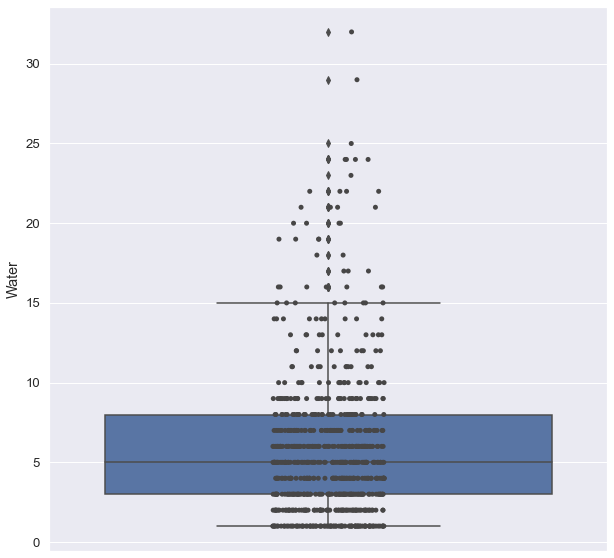

In [160]:
#Let us see if we have some outliers .... Yes here are some outliers in Water
sns.boxplot(y='Water', data=df)
sns.stripplot(y='Water', data=df, color="#474646")

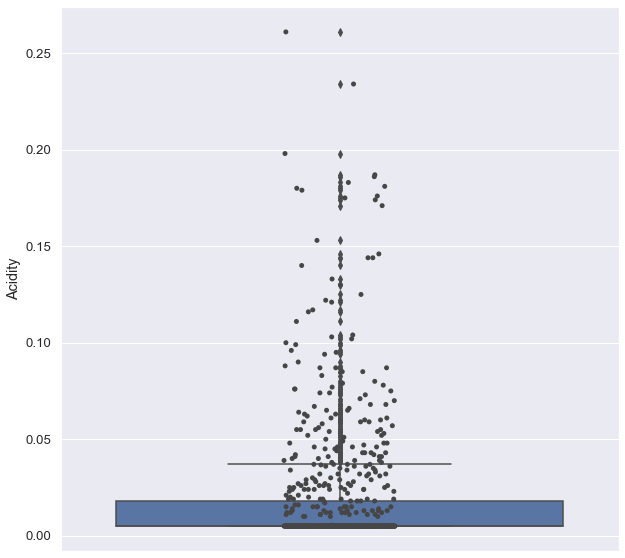

In [10]:
#Here, FOR ACIDITY there is alot of outliers. we may need to normalise or manipulate the outliers
sns.boxplot(y='Acidity', data=df)
sns.stripplot(y='Acidity', data=df, color="#474646")

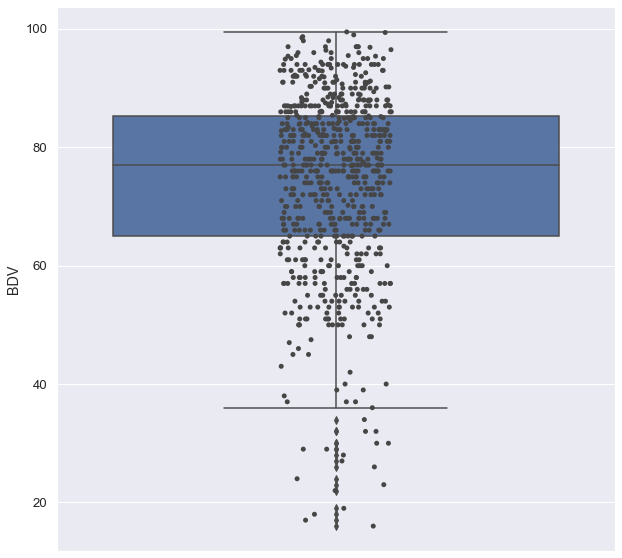

In [11]:
#FOR BDV , Here there is alot of outliers. we may need to normalise or manipulate the outliers
sns.boxplot(y='BDV', data=df)
sns.stripplot(y='BDV', data=df, color="#474646")

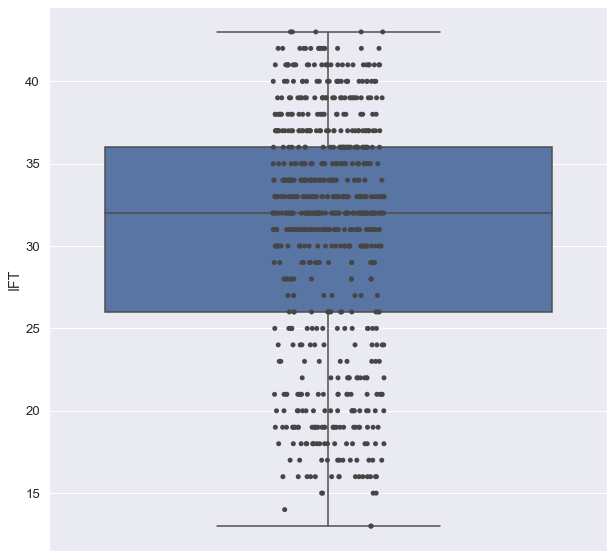

In [12]:
#Here, FOR IFT there isn't outliers.
sns.boxplot(y='IFT', data=df)
sns.stripplot(y='IFT', data=df, color="#474646")

In [74]:
#Checking count of outlier manually, I will be updating them later on inshAllah but just to have a view.
for col in df.columns:
    outliers_indices = ds.structdata.detect_outliers(df, 0, [col])
    print(f'in col: {col} , there is about {len(outliers_indices)} outliers\n')
    #col_median = df[col].median()
    #df[col].iloc[outliers_indices] = col_median
    


in col: Water , there is about 36 outliers

in col: Acidity , there is about 114 outliers

in col: BDV , there is about 17 outliers

in col: Colour , there is about 87 outliers

in col: IFT , there is about 0 outliers



# Some visualization

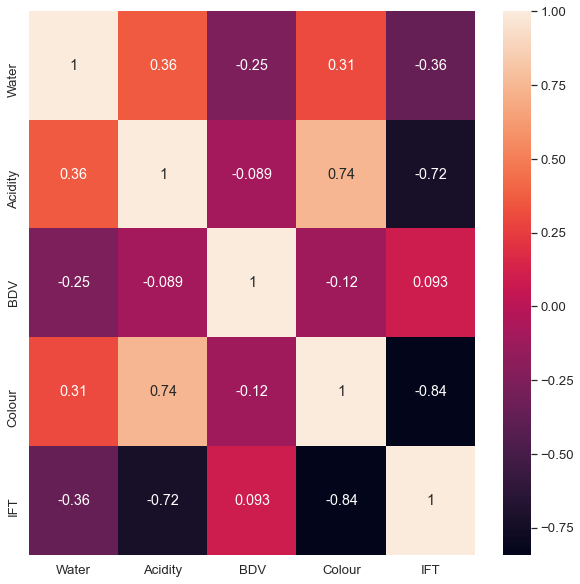

In [17]:
#Getting the correlation...
sns.heatmap(df.corr(),annot=True)

#These are the highlights 
#Acidity have high correlation with IFT , 
#COLOR have high correlation with IFT 
#Color have correlation with acidity .. which is logical 


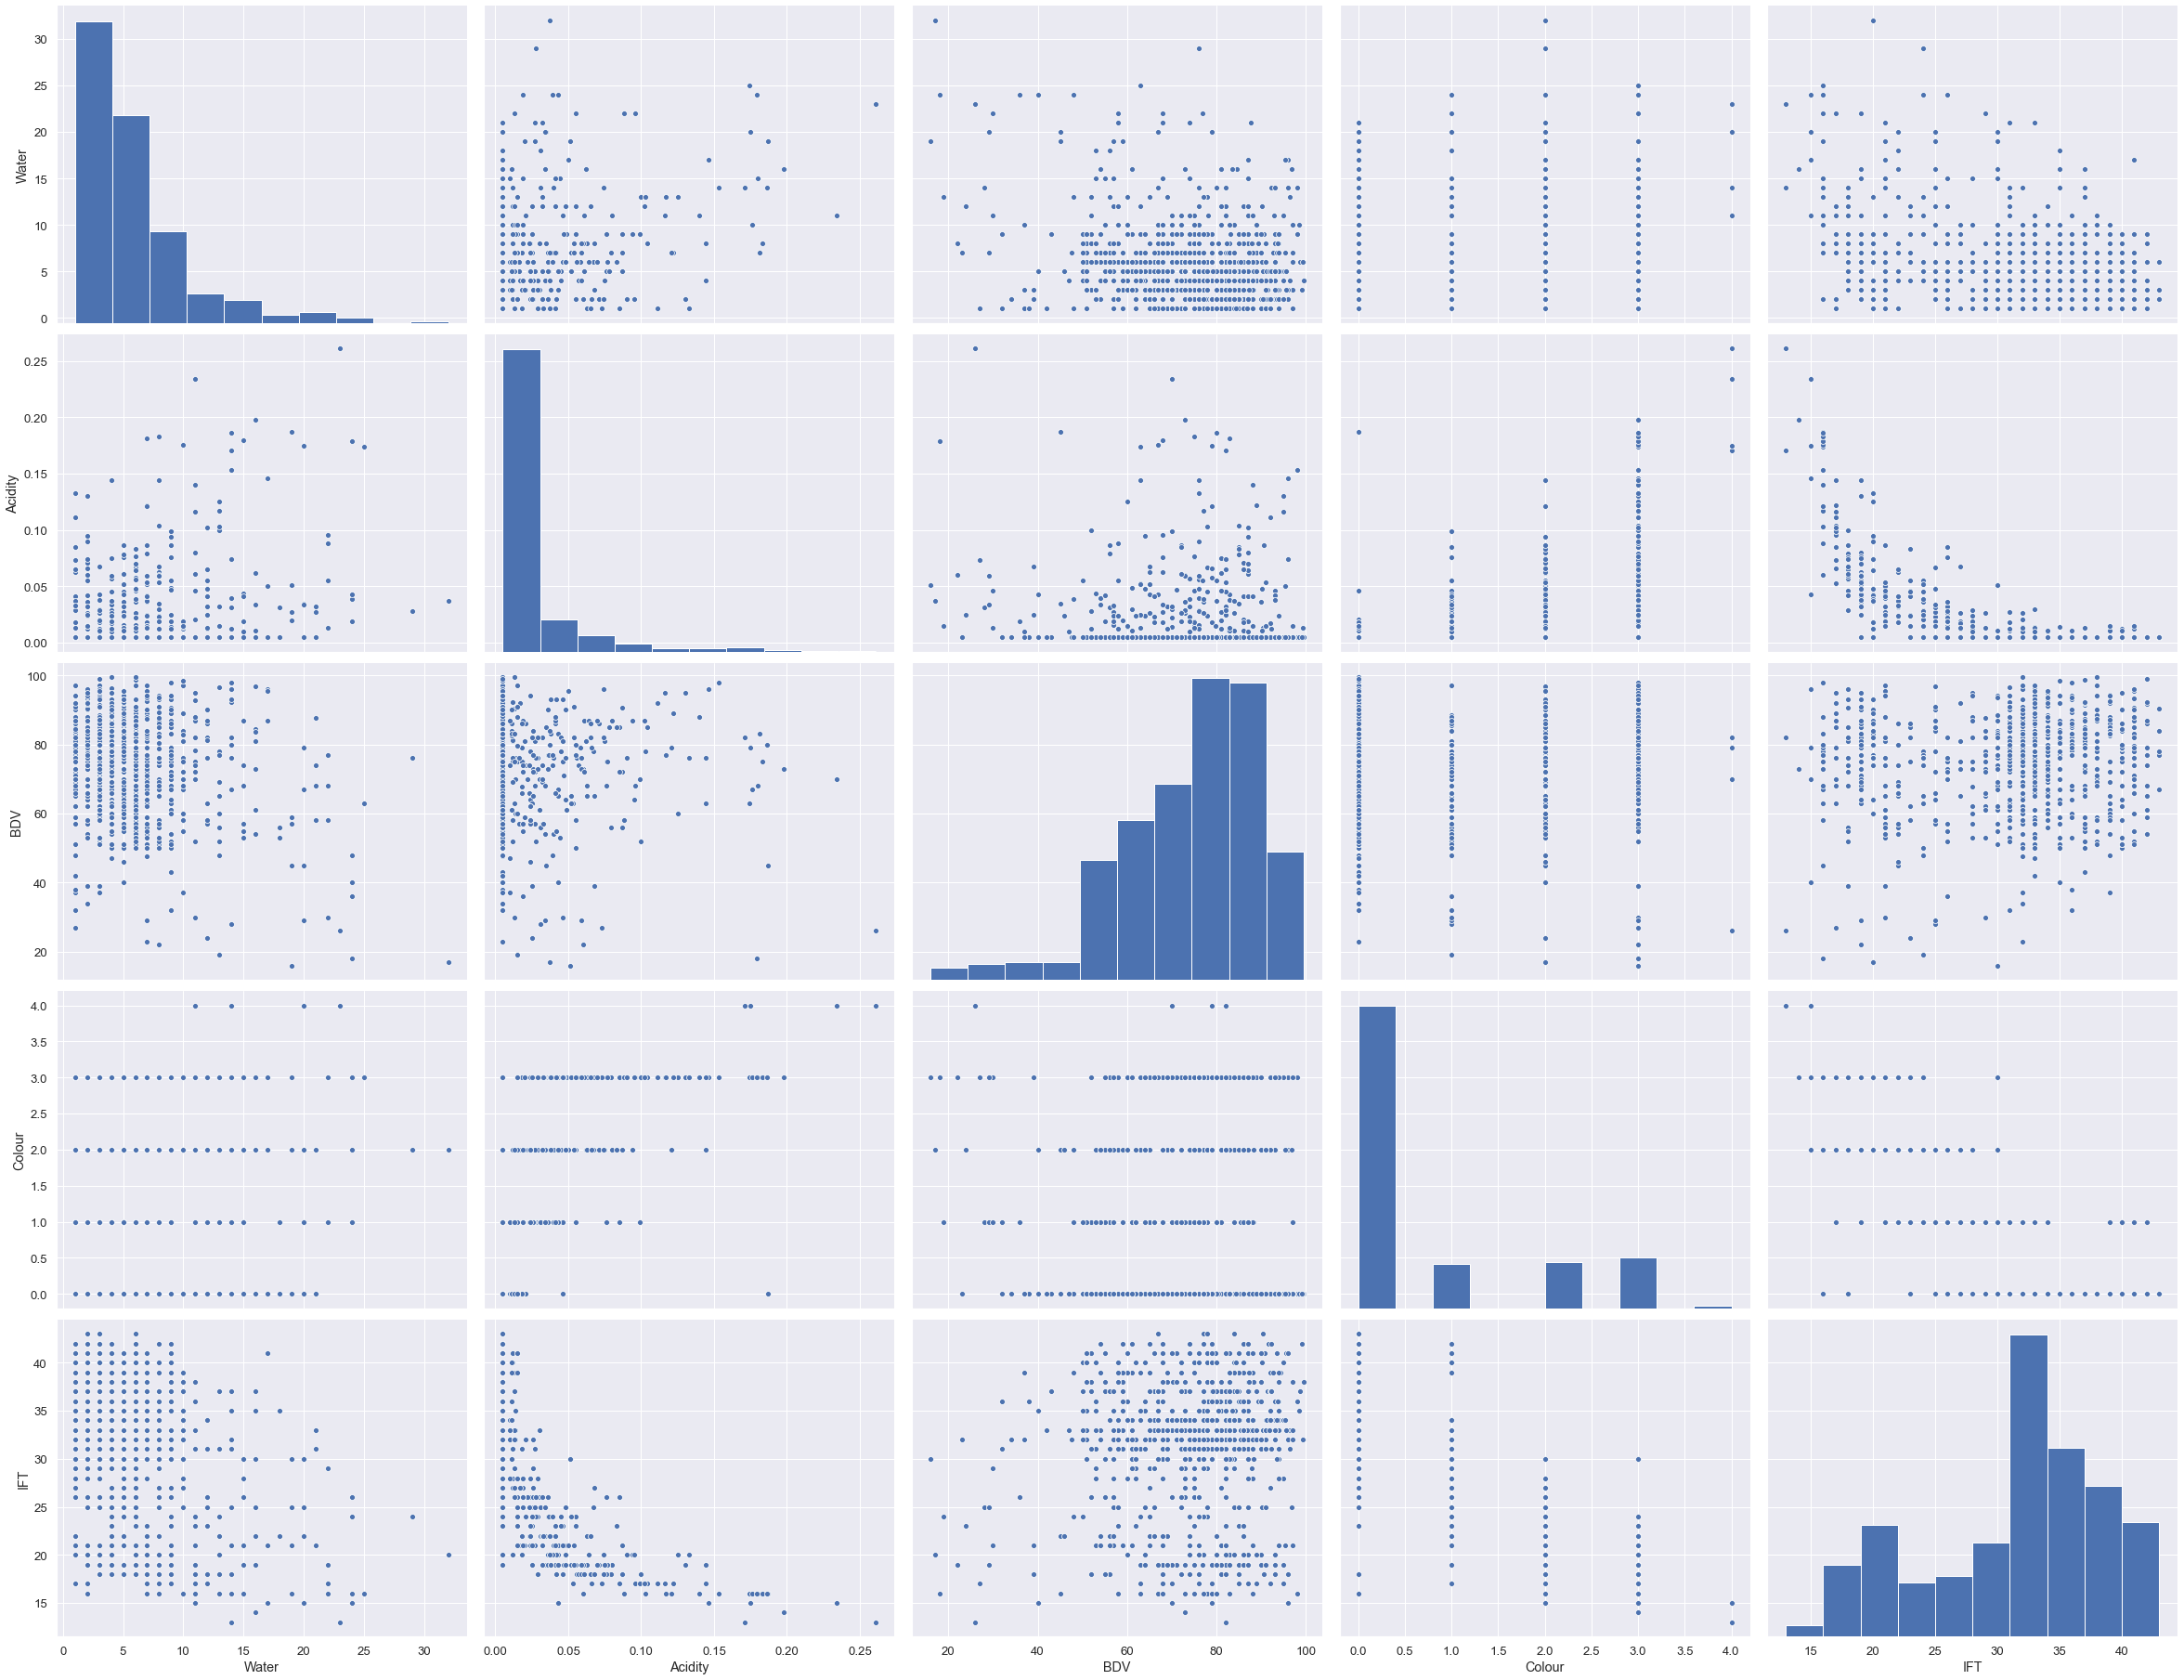

In [18]:
#Let us visuallize the correlation using pairplot & knowing the distubution plot
# We clearly can see the negative correlation in what we mentioned in :
#Acidity have high correlation with IFT  && COLOR have high correlation with IFT 
sns.pairplot(df,height=5, aspect=1.3)

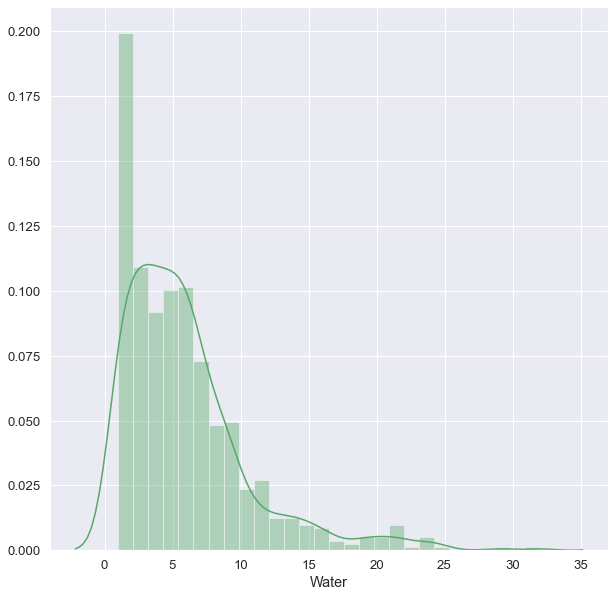

In [26]:
#Extra visulization for each plot 
sns.distplot(df['Water'],color='g') #Most Water content 0.2 , skewed right graph

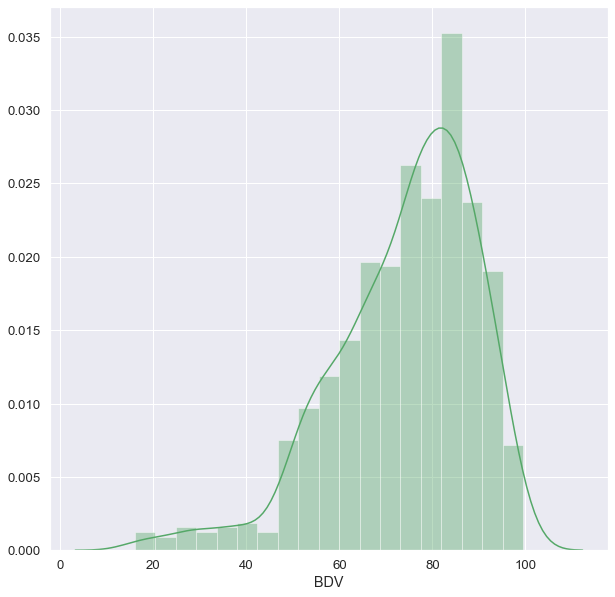

In [27]:
sns.distplot(df['BDV'],color='g') #Most BREAKDOWN-VOLTAGE is roughly 85, skewed left graph, maybe we need to Log scale or do other opertions


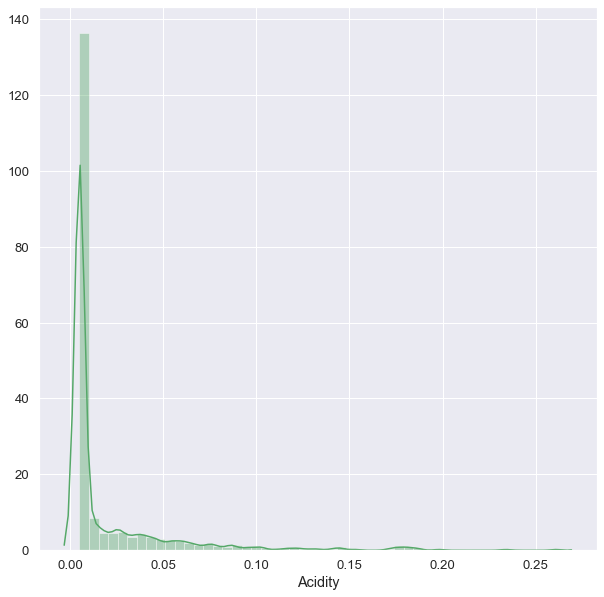

In [24]:
sns.distplot(df['Acidity'],color='g') #Very skewed data for Acidity , most used value is about 0.01
#We will deal with it in the preprocessing part

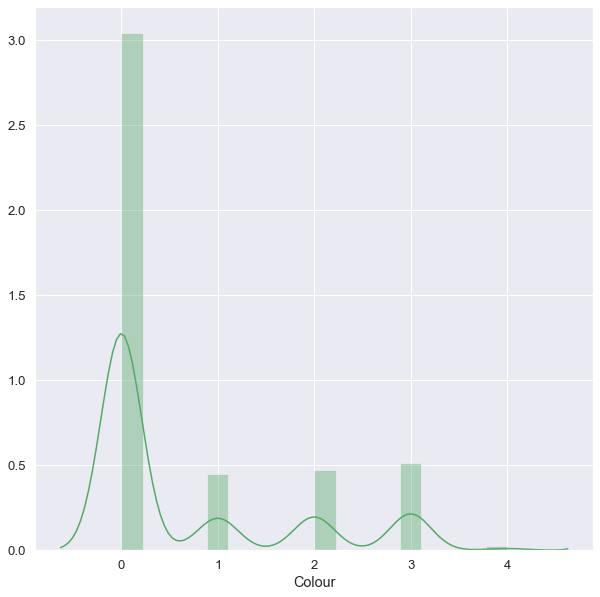

In [25]:
sns.distplot(df['Colour'],color='g')
#color 0 is the most common color

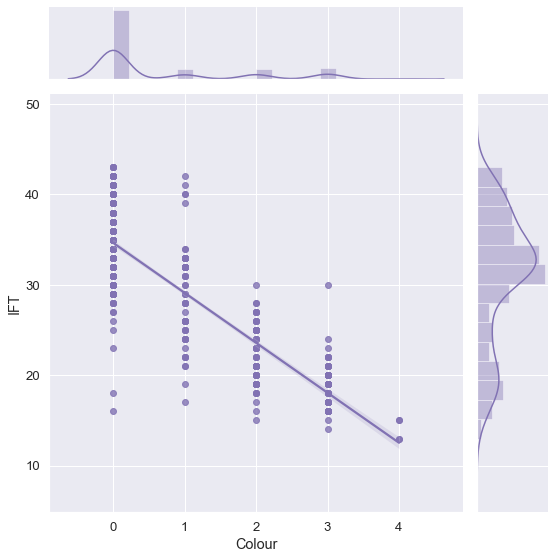

In [29]:
#Not nessecary but it just shows that we have a relation between IFT & COLOUR 
#HIGHER IFT , MAYBE DARKER THE COLOR (O-4)
sns.jointplot(x='Colour', y='IFT', data=df, kind='reg', height=8, color='m')

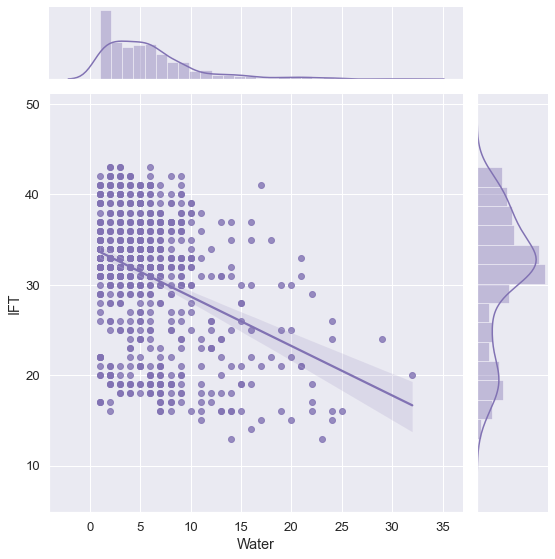

In [161]:
sns.jointplot(x='Water', y='IFT', data=df, kind='reg', height=8, color='m') #IFT Regression estimation using visualization

# 3)Preprocessing (changing outliers to median ,standered scaling data)

In [162]:
#drop column IFT (not removing it totally ... just temprary to store into x)
# I Do this step so that later on i do scaling on X features not on Y as well
x=df.drop('IFT',axis=1) #get all features expect IFT
y = df['IFT']  # get only IFT 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1) #splitting data into 80/20

In [163]:
#Actually This did not help at all raising the accuracy...
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
#We are scaling it here but not very much useful ... maybe we can just skip it 

StandardScaler()

In [164]:
#Removing Outliers .... 
for col in df.columns:
    outliers_indices = ds.structdata.detect_outliers(df, 0, [col]) #0 specify all of the ro w
    print(f'in col: {col} , there is about {len(outliers_indices)} outliers\n')
    col_median = df[col].median()
    df[col].iloc[outliers_indices] = col_median

in col: Water , there is about 36 outliers

in col: Acidity , there is about 114 outliers

in col: BDV , there is about 17 outliers

in col: Colour , there is about 87 outliers

in col: IFT , there is about 0 outliers



/Users/mac/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


# Building & Trying Model (RandomForest,XGBClassfier,LinearRegression)

## Now , checking with RandomForest 

In [165]:
#Bad result.... will not caluclate R2 for it , will only calculate it for the best classfier OK ?
model = RandomForestClassifier(n_estimators=200)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
#accuracy_score(y_test, y_pred)

In [166]:
model.score(x_train, y_train)  #R2 Score is about 0.85 of 1 , in the training data

0.8507718696397941

In [167]:
model.score(x_test, y_test)  #R2 Score is about 0.13 of 1 , in the training data

0.13013698630136986

## Now , checking with XGB 

In [168]:
#Bad result.... will not caluclate R2 for it , will only calculate it for the best classfier OK ?

#Now , checking with XGB 
model = XGBClassifier(n_estimators=200)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
#accuracy_score(y_test, y_pred)

In [169]:
model.score(x_train, y_train)  #R2 Score is about 0.85 of 1 , in the training data

0.8507718696397941

In [170]:
model.score(x_test, y_test) #R2 Score is about 0.14 of 1 , in the training data

0.14383561643835616

## Now , checking with LinearRegression (Best Results) 

In [171]:
## Now , checking with LinearRegression

In [172]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [173]:
y_pred = model.predict(x_test)
y_pred

array([34.40729565, 34.74431767, 22.58977876, 35.11273407, 33.74119189,
       34.33979864, 34.23684541, 34.03595303, 35.0983297 , 35.73950316,
       34.48337936, 17.06352998, 27.73448511, 19.45744942, 34.48402576,
       34.77054079, 34.14759905, 34.31971935, 34.22899682, 34.76989438,
       17.46603173, 20.28514369, 34.16212788, 23.97334997, 22.98587416,
       18.34760975, 35.09703688, 35.52971825, 34.60267618, 18.29663386,
       35.08392533, 34.645981  , 35.13637155, 34.64007163, 34.54132299,
       34.95410258, 30.07630084, 34.92658665, 34.21261654, 34.64071804,
       34.01330254, 34.75936845, 34.71938738, 34.3529102 , 29.80597027,
       30.86706856, 35.13766437, 30.47501468, 24.8579517 , 34.53320327,
       34.55152277, 35.30682179, 34.1437717 , 29.60509233, 35.13637155,
       34.15032748, 19.12463395, 35.17570622, 34.45844906, 18.91986116,
       34.9141215 , 15.93099065, 32.78921952, 13.98897518, 34.20932948,
       34.41846798, 19.31742689, 35.21504089, 24.54780116, 25.51

In [174]:
y_test #This is the acutal value, our preductions was kind of very close to them

248    32
674    31
159    21
355    35
510    37
       ..
689    42
464    22
693    40
40     24
604    31
Name: IFT, Length: 146, dtype: int64

##  Calculate Root Mean Square Error

In [175]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_test, y_pred))  #The diffrence is ±3.2 between real & my data 

3.2333231085928813

## 7) Calculate R2 Score

In [176]:
model.score(x_train, y_train)  #R2 Score is about 0.72 of 1 , in the training data

0.7277179768539358

In [177]:
model.score(x_test, y_test)  #Actually it perfromes better on the testing data =D 0.77 out of 1 

0.7733005815194948

In [178]:
pd.DataFrame(model.coef_, x.columns, columns=["Coeff"]) #These are the coffecient for Multi-Linear Regreisson

,Coeff
Water,-0.130469
Acidity,-38.202966
BDV,-0.013112
Colour,-4.479088


In [109]:
print(50*"*")
print(50*"*")
print(50*"*")
print("Second Part")

**************************************************
**************************************************
**************************************************
Second Part


# Part-2 , The classficiation .....
 1. ADD THE NEW COLUMN (CATEGORY)
 2. UPDATE CATEGORY VALUE
 3. DROP IFT (BECAUSE OF HIGH CORRELATION...) 
 4. Splitting data
 5. TRYING MULTIPLE CLASSFIERS

In [179]:
#Creating a new column with copied values to edit later...
df['category']=   df['IFT']

#Now we use the apply methode to apply this function on each row...
def giveClasses(val):
    if (val>=30):
        return "Class1"
    return "Class2"

#Here applying the function ... now we will have class1 & class2 as usuall 
df['category']=df['category'].apply(giveClasses)

In [135]:
df.head(2) #watching the diffrences 

,Water,Acidity,BDV,Colour,IFT,category
0,13.0,0.005,48.0,2.0,24.0,Class2
1,5.0,0.005,68.0,0.0,17.0,Class2


In [180]:
df.drop('IFT',axis=1,inplace=True) 

In [181]:
x=df.drop('category',axis=1) #drop column IFT (not removing it totally ... just temprary to store into x)
y = df['category']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

## Let's try RANDOMFOREST

In [182]:
model = RandomForestClassifier(n_estimators=500)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(f"Accuracy => {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred)) #Accuracy is 0/76 , other metrics are 

Accuracy => 0.7602739726027398
              precision    recall  f1-score   support

      Class1       0.79      0.88      0.83        96
      Class2       0.69      0.54      0.61        50

    accuracy                           0.76       146
   macro avg       0.74      0.71      0.72       146
weighted avg       0.75      0.76      0.75       146



## Let's try BOOSTING

In [147]:
#Bad result.... will not caluclate R2 for it , will only calculate it for the best classfier OK ?

#Now , checking with XGB 
model = XGBClassifier(n_estimators=500)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(f"Accuracy => {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred)) #Got 0.78 accuracy 

Accuracy => 0.7808219178082192
              precision    recall  f1-score   support

      Class1       0.80      0.90      0.84        96
      Class2       0.74      0.56      0.64        50

    accuracy                           0.78       146
   macro avg       0.77      0.73      0.74       146
weighted avg       0.78      0.78      0.77       146



## Let's try LOGISTRIC REGRESSION

In [149]:
#Tring Logistic regresser 
model = LogisticRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy_score(y_test, y_pred)
print(f"Accuracy => {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred)) #Got 0.76 accuracy 

Accuracy => 0.7602739726027398
              precision    recall  f1-score   support

      Class1       0.76      0.94      0.84        96
      Class2       0.78      0.42      0.55        50

    accuracy                           0.76       146
   macro avg       0.77      0.68      0.69       146
weighted avg       0.76      0.76      0.74       146



## Let's try SVC

In [150]:
model = SVC()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy_score(y_test, y_pred)
print(f"Accuracy => {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred)) #Got 0.78 accuracy 

Accuracy => 0.6575342465753424
              precision    recall  f1-score   support

      Class1       0.66      1.00      0.79        96
      Class2       0.00      0.00      0.00        50

    accuracy                           0.66       146
   macro avg       0.33      0.50      0.40       146
weighted avg       0.43      0.66      0.52       146



/Users/mac/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Let's try KNN

In [151]:

model =KNeighborsClassifier(n_neighbors=30)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy_score(y_test, y_pred)

0.684931506849315

In [183]:
cv_result = cross_validate(model,x_train,y_train,cv=10,return_train_score=True)
cv_result['test_score'].mean() # The Cross-validation result of 10

0.7990940970192868